In [1]:
import ceo
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
#import scipy
#import cupyx.scipy.signal

/home/ubuntu/CEO/python/ceo/zemax


# Holographic Dispersed Fringe Sensor Demo
Sensor designed by Sebastiaan Haffert, optimized for NGWS 2nd channel application.

## Initialize Telescope

In [2]:
gmt = ceo.GMT_MX()
gmt.M2_baffle = 3.5    # Circular diameter pupil mask obscuration
gmt.project_truss_onaxis = True

PupilArea = 358.0 # m2
D = 25.5

## HDFS and GS initialization

In [3]:
mag = 12.0
tel_throughput = 0.9**4 # M1 + M2 + M3 + GMTIFS dichroic = 0.9^4
ngws_throughput =  tel_throughput * 0.4  # NGWS board: 0.4
sps_throughput  = ngws_throughput * 0.1 * 0.8  # light sent to 2nd visible channel + 2nd channel throughput (TBD)

In [4]:
# DFS GS custom band
wl2nd = 800e-9
delta_wl2nd = 200e-9

#---- Scale zeropoint for the desired bandwidth:
e0_RIband = 9e12 # zeropoint in photons/s in R+I band over the GMT pupil (check official photometry table!)
delta_wl_RIband = 300e-9  # check official photometry table!
e0_wl2nd = e0_RIband * (delta_wl2nd/delta_wl_RIband) / PupilArea    #in ph/m^2/s in the desired bandwidth
#print("Zero point [ph/m^2/s]: %.3e"%e0_wl2nd)
print('Zero point [ph/s]: %.3e'%(e0_RIband * (delta_wl2nd/delta_wl_RIband)))
sps_band = [wl2nd, delta_wl2nd, e0_wl2nd]

sps_nPx = 512         # number of rays to propagate from GS to SPS
sps_pixelSize = D/(sps_nPx-1)
bkgd_mag = 19.6       # sky bkgd (mag/arcsec^2); Tech Note GMT-02274, rev 2.4

sps_mag = [mag]
gsps = ceo.Source(sps_band, magnitude=sps_mag, zenith=0.,azimuth=0.,
                  rays_box_size=D,rays_box_sampling=sps_nPx,rays_origin=[0.0,0.0,25])

print('Photometry in custom band:')
for x in range(gsps.N_SRC):
    print('Number of simulated GS photons [ph/m^2/s]: %.1f'%(gsps.nPhoton[x]*sps_throughput))
    # ---- Expected flux without vignetting (i.e. on-axis GS)
    print('Number of  expected GS photons [ph/m^2/s]: %.1f'%(sps_throughput*e0_wl2nd*10**(-0.4*sps_mag[x])))

Zero point [ph/s]: 6.000e+12
Photometry in custom band:
Number of simulated GS photons [ph/m^2/s]: 5576.8
Number of  expected GS photons [ph/m^2/s]: 5576.8


In [6]:
#--- Instantiate HDFS
sps_fov = 1.4 #arcsec diameter
sps_nyquist_factor = 1.5
sps_throughput  = ngws_throughput * 0.1 * 0.8
sps_spectral_type='tophat'
sps_apodization_window_type='Tukey'
sps_processing_method='DFS'
sps_fs_shape = 'round'
sps_fs_dim_mas = 40 # field stop radius [mas]

ps = ceo.HolographicDFS(cwvl=wl2nd, wvl_band=[wl2nd-delta_wl2nd/2, wl2nd+delta_wl2nd/2], wvl_res=10e-9, 
            nyquist_factor=sps_nyquist_factor, fov_mas=sps_fov*1e3,
            fs_shape=sps_fs_shape,fs_dim_mas=sps_fs_dim_mas, 
            spectral_type=sps_spectral_type, 
            apodization_window_type=sps_apodization_window_type,
            processing_method=sps_processing_method, throughput=sps_throughput)

Filename: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_v1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (512, 512)   float64   


## HDFS calibration
1. Stores pointers to GS wavefront (to avoid GPU-CPU transfers)
2. Computes the reference measurement vector (for a flat WF)

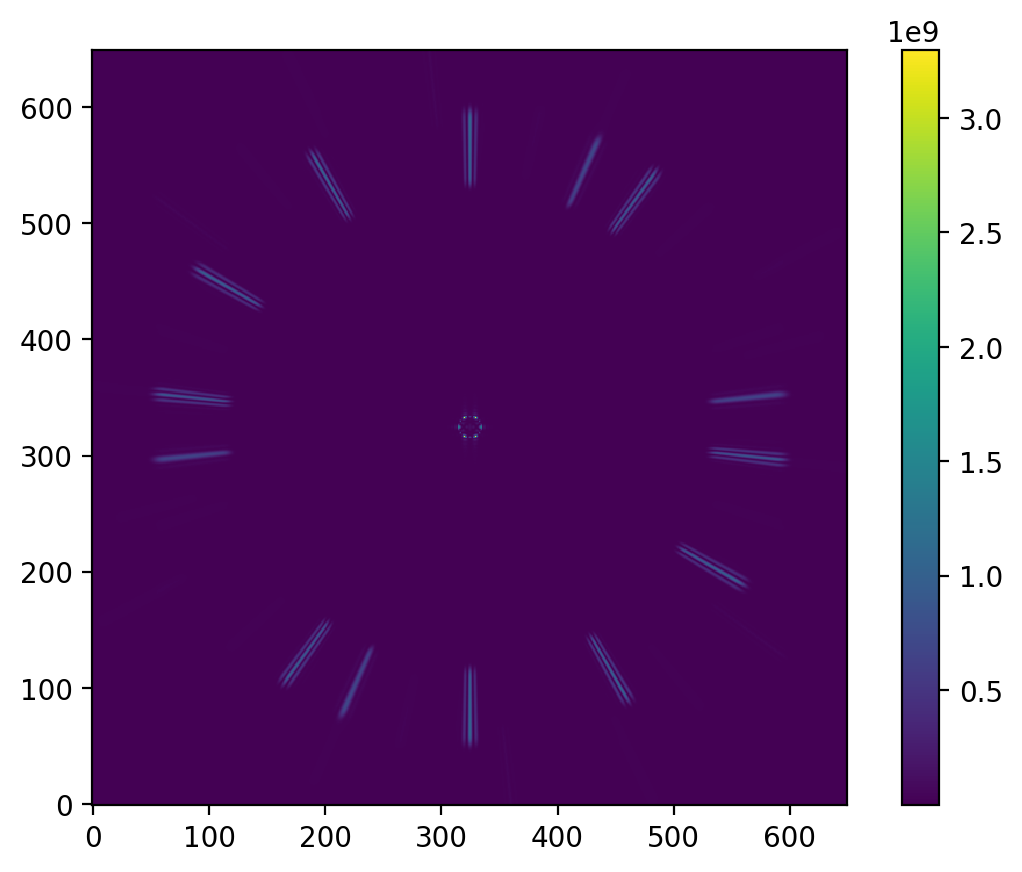

In [7]:
gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.calibrate(gsps)

fig, ax1 = plt.subplots()
fig.set_size_inches((7,5))
fig.dpi = 200
imm1 = ax1.imshow(ps._image.get(),origin='lower', interpolation='None')
clb1 = fig.colorbar(imm1, ax=ax1)

### Show fringes

In [8]:
def show_hdfs_fringes(apodize=True, normalize=False, derotate=False, full=True):
    fringes = ps.extract_fringes(apodize=apodize, normalize=normalize, derotate=derotate)
    if full:
        fig, ax = plt.subplots(ncols=7, nrows=2)
        fig.set_size_inches((10,3))
        fig.dpi=300
        for k in range(ps._N_FRINGES):
            (ax.ravel())[k].imshow(fringes[:,:,k].get(), cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')
    else:
        fig, ax = plt.subplots(ncols=7, nrows=1)
        fig.set_size_inches((10,1.5))
        for k in range(int(ps._N_FRINGES/2)):
            (ax.ravel())[k].imshow(fringes[:,:,k].get(), cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')

    plt.tight_layout()

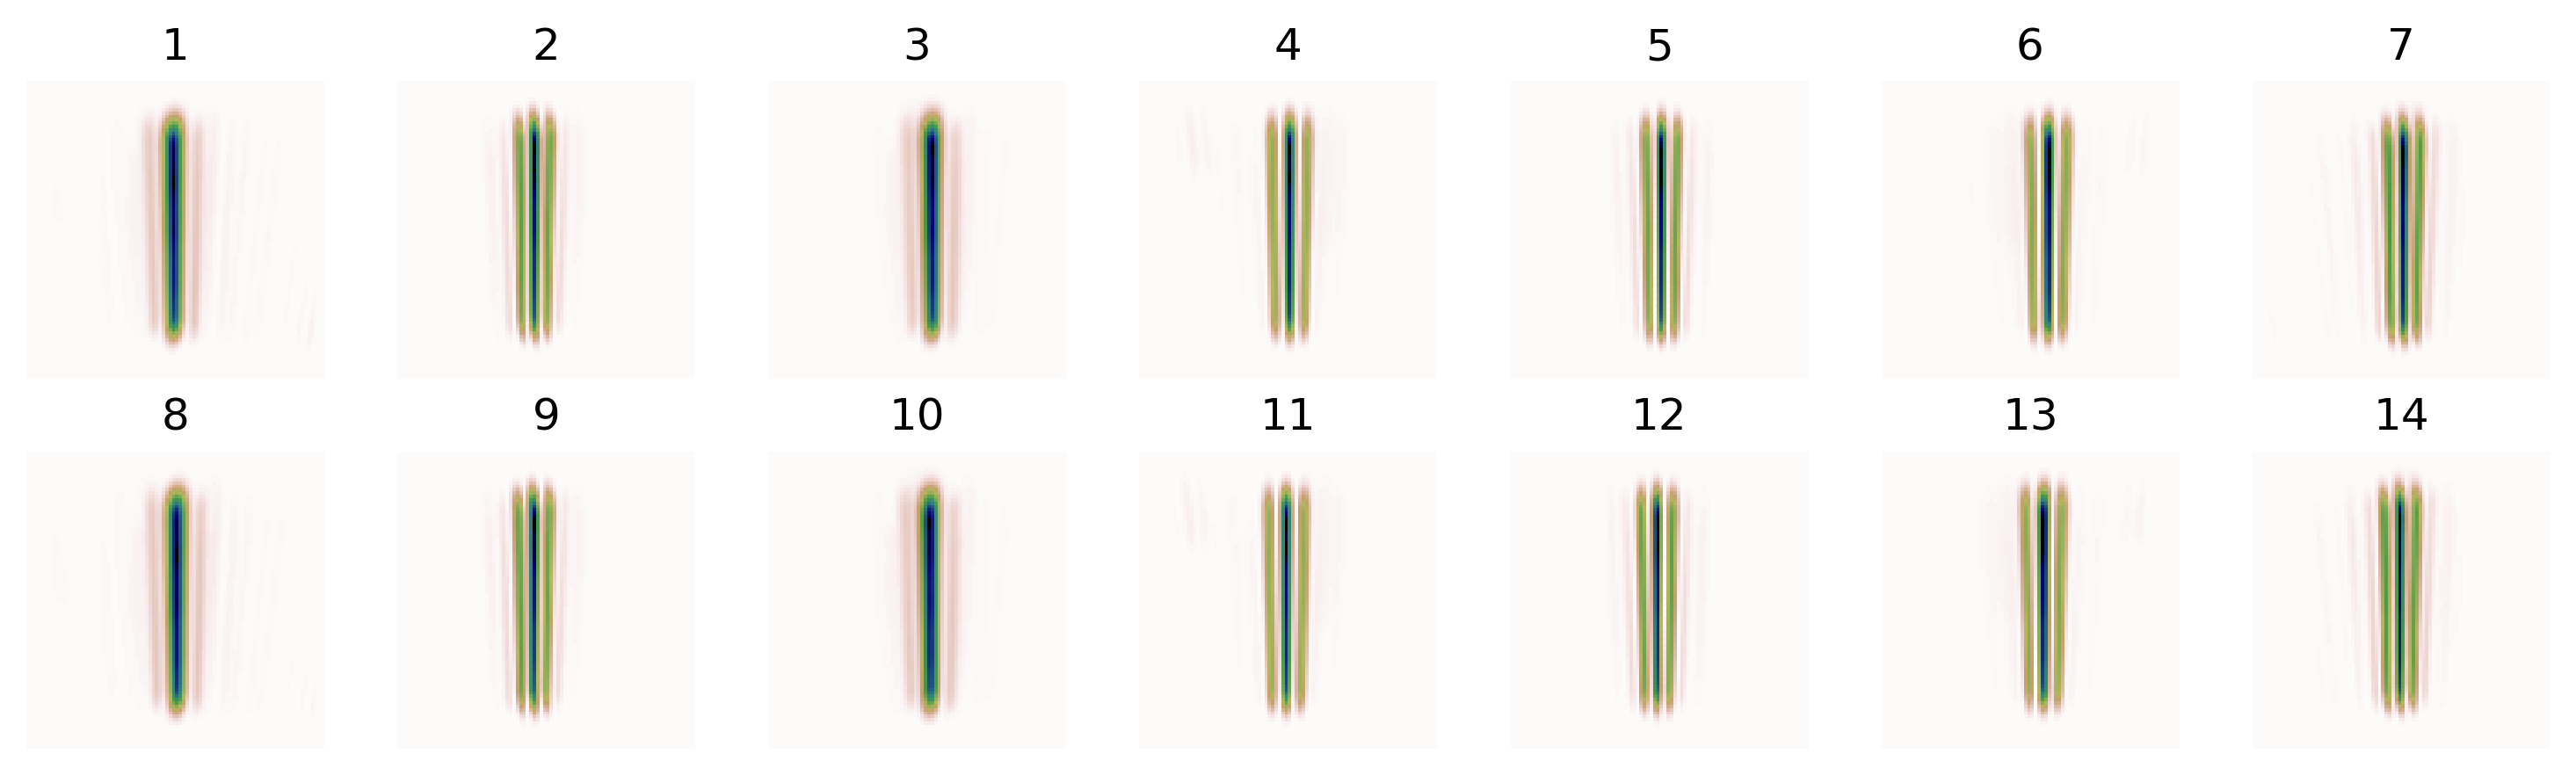

In [9]:
show_hdfs_fringes(apodize=True, normalize=False, derotate=True, full=True)

### Estimate number of photons per SA per second
Note: Flux estimation must be done on unrotated fringes to avoid artifacts

In [12]:
this_mag = [10,12,14,16]
nmag = len(this_mag)
nphsspp = cp.zeros((ps._N_FRINGES,nmag))
exposureTime = 1.0
gmt.reset()
for mm in range(nmag):
    gsps.magnitude = [this_mag[mm]]
    gsps.reset()
    gmt.propagate(gsps)
    ps.calibrate(gsps)
    ps.reset()
    ps.propagate(gsps)
    ps.noiselessReadOut(exposureTime)
    fringes = ps.extract_fringes(apodize=True, normalize=False, derotate=False)
    nphsspp[:,mm] = cp.sum(cp.reshape(fringes,(-1,ps._N_FRINGES)),axis=0)

print('R-mag:')
print(this_mag)
print('nph per SA per second:')
print(cp.array_str(cp.mean(nphsspp,axis=0),precision=1))

R-mag:
[10, 12, 14, 16]
nph per SA per second:
[700184.9 110971.8  17587.9   2787.5]


## Simple segment piston estimation demo

### Calibrate interaction matrix
Using M1 segment piston (Tz) here.

In [14]:
poke = 1e-6
imat = np.zeros((14,7))
for segID in range(7):
    gmt.reset()
    gmt.M1.motion_CS.origin[segID,2] = poke
    gmt.M1.motion_CS.update()
    gsps.reset()
    gmt.propagate(gsps)
    ps.reset()
    ps.propagate(gsps)
    ps.process()
    mes = ps.get_measurement()
    imat[:,segID] = mes/poke

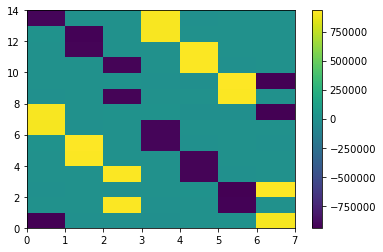

In [15]:
plt.pcolor(imat)
plt.colorbar()

### Compute reconstruction matrix
Here is a simple LS rec

In [26]:
noise = np.zeros(ps._N_FRINGES)+1.
cnninv = np.diag(1./noise)
pistonpen = 1e15*np.ones((7,7))
cmat = np.linalg.solve(imat.T@cnninv@imat+pistonpen,imat.T@cnninv)

### Test 1. Estimate a given static segment piston scramble

In [36]:
gsps.magnitude = [12.0]

gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.reset()
ps.calibrate(gsps)

exposureTime = 150e-3

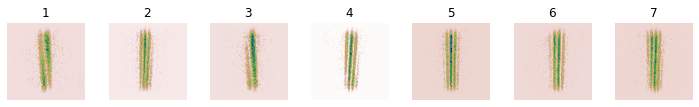

In [37]:
gmt.reset()
pistScramble = np.array([2.96428571e-07, -1.53571429e-07,  1.04642857e-06, -4.53571429e-07,-2.03571429e-07,  1.71428571e-07, -7.03571429e-07])
gmt.M1.motion_CS.origin[:,2] = pistScramble
gmt.M1.motion_CS.update()
gsps.reset()
gmt.propagate(gsps)
ps.reset()
ps.propagate(gsps)

#ps.noiselessReadOut(exposureTime)
ps.readOut(exposureTime)
ps.process()
mes = ps.get_measurement()
pistEst = cmat@mes

show_hdfs_fringes(apodize=True, normalize=False, derotate=True, full=False)

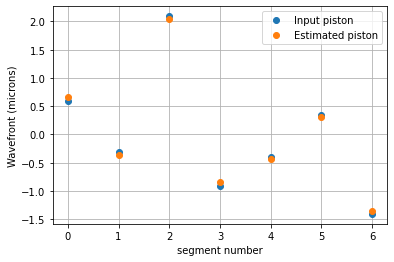

In [38]:
plt.plot(pistScramble*2e6,'o',label='Input piston')
plt.plot(pistEst*2e6,'o',label='Estimated piston')
plt.ylabel("Wavefront (microns)")
plt.xlabel("segment number")
plt.grid()
plt.legend()